In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# %load ../structural_breaks.py
def compute_bsadf(logP, minSL, maxSL, constant, lags):
    df0 = pd.DataFrame(index=log_p.index, columns=['bsadf'])
    for j in range(minSL+1, log_p.shape[0]): 
        res = get_bsadf(log_p[:j].to_frame(), minSL, maxSL, constant, lags)
        df0.loc[res['Time']] = res['bsadf']
    return df0

def get_bsadf(logP, minSL, maxSL, constant, lags):
    '''
    See Advances in Financial Analytics, snippet 17.1, page 258.

    @param logP A series containing log-prices.
    @param minSL the minimum sample length (tau), used by the final regression.
    @param constant The regression's time trend component. When:
        - 'nc': no time trend, only a constant.
        - 'ct': a constant plus a linear polynomial time trend.
        - 'ctt': a constant plus a second-degree polynomial time trend.
    @param lags The number of lags used in the ADF specification.
    '''
    y,x = getYX(logP, constant=constant, lags=lags)
    # Wraps the range in such a way that enough information is taken into
    # account and the problem keeps tractable.
    max_range = y.shape[0]+lags-minSL+1
    min_range = max(0, max_range - maxSL)
    startPoints, bsadf, allADF = range(min_range, max_range), None, []
    for start in startPoints:
        y_, x_ = y[start:], x[start:]
        bMean_, bStd_ = getBetas(y_, x_)
        bMean_, bStd_ = bMean_[0, 0], bStd_[0, 0]**0.5
        if np.isnan(bMean_): raise ValueError('bMean_ is nan. y_: {} | x_: {} | bMean_: {}'.format(y_, x_, bMean_))
        if np.isnan(bStd_): raise ValueError('bStd_ is nan. y_: {} | x_: {} | bStd_: {}'.format(y_, x_, bStd_))
        allADF.append(bMean_ / bStd_)
        # if not bsadf or allADF[-1] > bsadf: bsadf = allADF[-1]
        # if not bsadf: bsadf = allADF[-1]
        # elif allADF[-1] > bsadf: bsadf = allADF[-1]
    bsadf = max(allADF)
    out = {'Time': logP.index[-1], 'bsadf': bsadf}
    return out

def getYX(series, constant, lags):
    '''
    See Advances in Financial Analytics, snippet 17.2, page 258.
    '''
    series_ = series.diff().dropna()
    x = lagDF(series_, lags).dropna()
    x.iloc[:, 0] = series.values[-x.shape[0]-1:-1,0] # Lagged level
    y = series_.iloc[-x.shape[0]:].values
    if constant != 'nc':
        x = np.append(x, np.ones((x.shape[0], 1)), axis=1)
        if constant == 'ct':
            trend = np.arange(x.shape[0]).reshape(-1, 1)
            x = np.append(x, trend, axis=1)
        if constant == 'ctt':
            trend = np.arange(x.shape[0]).reshape(-1, 1)
            x = np.append(x, trend**2, axis=1)
    return y, x

def lagDF(df0, lags):
    '''
    See Advances in Financial Analytics, snippet 17.3, page 259.
    '''
    df1 = pd.DataFrame()
    if isinstance(lags, int): lags = range(lags + 1)
    else: lags = [int(lag) for lag in lags]
    for lag in lags:
        df_ = df0.shift(lag).copy(deep=True)
        df_.columns = [str(i)+'_'+str(lag) for i in df_.columns]
        df1 = df1.join(df_, how='outer')
    return df1

def getBetas(y, x):
    '''
    See Advances in Financial Analytics, snippet 17.4, page 259.
    '''
    xy = np.dot(x.T, y)
    xx = np.dot(x.T, x)
    xxinv = np.linalg.inv(xx)
    bMean = np.dot(xxinv, xy)
    err = y-np.dot(x, bMean)
    bVar = np.dot(err.T, err) / (x.shape[0] - x.shape[1]) * xxinv
    return bMean, bVar


In [3]:
PERIODICITY='daily'

In [4]:
# Función que permite convertir el formato de las fechas como string
# en un objeto de fecha.
string_to_date = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")

In [5]:
if PERIODICITY=='hourly':
    DATA_PATHS = ['../../datasets/bitstamp_data_hourly.csv']
elif PERIODICITY=='daily':
    DATA_PATHS = ['../../datasets/bitstamp_data_daily.csv']
else:
    DATA_PATHS = ['../../datasets/bitstamp_data.csv.part1', '../../datasets/bitstamp_data.csv.part2',
                  '../../datasets/bitstamp_data.csv.part3', '../../datasets/bitstamp_data.csv.part4',
                  '../../datasets/bitstamp_data.csv.part5']

In [30]:
def load_btc_data(file_paths):
    # Función que permite convertir el formato de las fechas como unix time
    # en un objeto de fecha.
    unix_time_to_date = lambda x: pd.to_datetime(x,unit='s')
    li = []
    for filename in file_paths:
        df = pd.read_csv(filename, parse_dates=['Timestamp'], date_parser=unix_time_to_date, index_col='Timestamp')
        li.append(df)
    return pd.concat(li, axis=0)

btc = load_btc_data(DATA_PATHS)
# btc.drop(['Weighted_Price'], axis=1)

In [35]:
log_p = btc['Close'].apply(lambda x: np.log(x)).dropna()
minSL = 50
maxSL = 300
constants = ['nt', 'ct', 'ctt']
lags = [1, 2, 3, 4, 5]

In [36]:
bsadf = pd.DataFrame(index=log_p.index, columns=['bsadf_{}_{}'.format(c, l) for c in constants for l in lags])

In [37]:
for constant in constants:
    for lag in lags:
        col_name = 'bsadf_{}_{}'.format(constant, lag)
        print('Computing {}'.format(col_name))
        df = compute_bsadf(log_p.to_frame(), minSL, maxSL, constant, lag)
        bsadf.loc[:, col_name] = df['bsadf']

Computing bsadf_nt_1
Computing bsadf_nt_2
Computing bsadf_nt_3
Computing bsadf_nt_4
Computing bsadf_nt_5
Computing bsadf_ct_1
Computing bsadf_ct_2
Computing bsadf_ct_3
Computing bsadf_ct_4
Computing bsadf_ct_5
Computing bsadf_ctt_1
Computing bsadf_ctt_2
Computing bsadf_ctt_3
Computing bsadf_ctt_4
Computing bsadf_ctt_5


In [38]:
btc = pd.merge(btc, bsadf, how='inner', left_index=True, right_index=True)
btc.dtypes

Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
bsadf_nt_1            object
bsadf_nt_2            object
bsadf_nt_3            object
bsadf_nt_4            object
bsadf_nt_5            object
bsadf_ct_1            object
bsadf_ct_2            object
bsadf_ct_3            object
bsadf_ct_4            object
bsadf_ct_5            object
bsadf_ctt_1           object
bsadf_ctt_2           object
bsadf_ctt_3           object
bsadf_ctt_4           object
bsadf_ctt_5           object
dtype: object

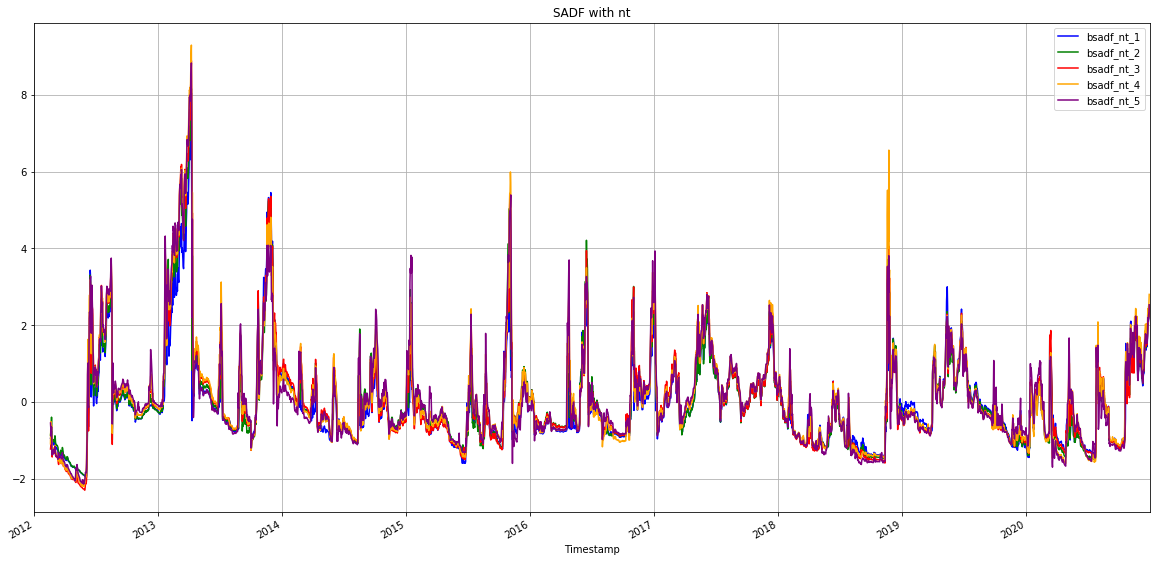

In [39]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
# btc.plot(kind='line',y='Close', color='blue', ax=ax)
btc.plot(kind='line',y='bsadf_nt_1', color='blue', ax=ax)
btc.plot(kind='line',y='bsadf_nt_2', color='green', ax=ax)
btc.plot(kind='line',y='bsadf_nt_3', color='red', ax=ax)
btc.plot(kind='line',y='bsadf_nt_4', color='orange', ax=ax)
btc.plot(kind='line',y='bsadf_nt_5', color='purple', ax=ax)
plt.title('SADF with nt')
plt.grid()
plt.show()

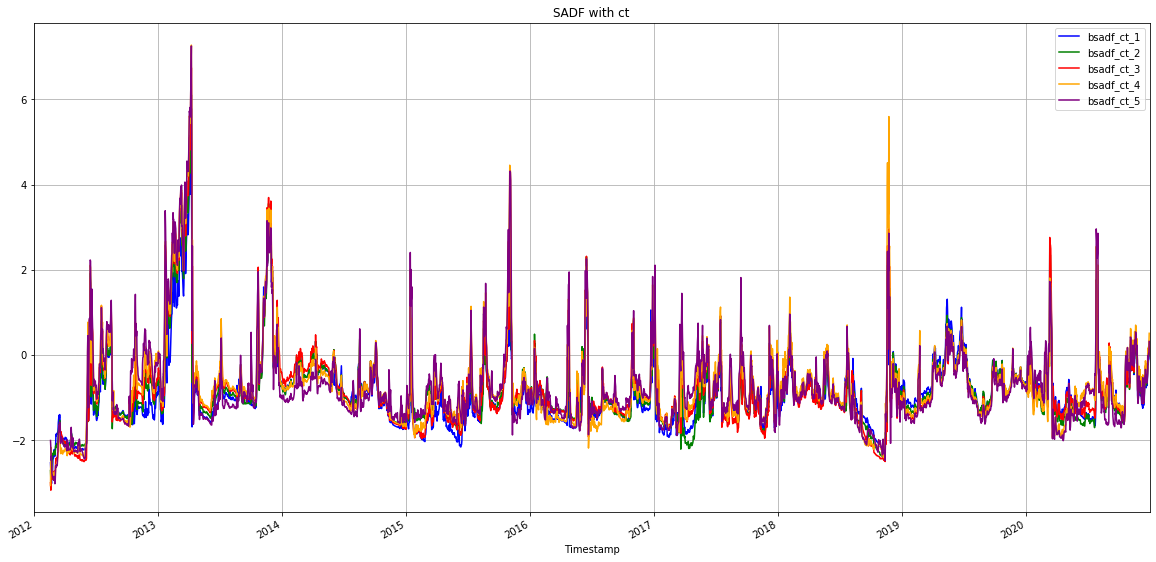

In [40]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
# btc.plot(kind='line',y='Close', color='blue', ax=ax)
btc.plot(kind='line',y='bsadf_ct_1', color='blue', ax=ax)
btc.plot(kind='line',y='bsadf_ct_2', color='green', ax=ax)
btc.plot(kind='line',y='bsadf_ct_3', color='red', ax=ax)
btc.plot(kind='line',y='bsadf_ct_4', color='orange', ax=ax)
btc.plot(kind='line',y='bsadf_ct_5', color='purple', ax=ax)
plt.title('SADF with ct')
plt.grid()
plt.show()

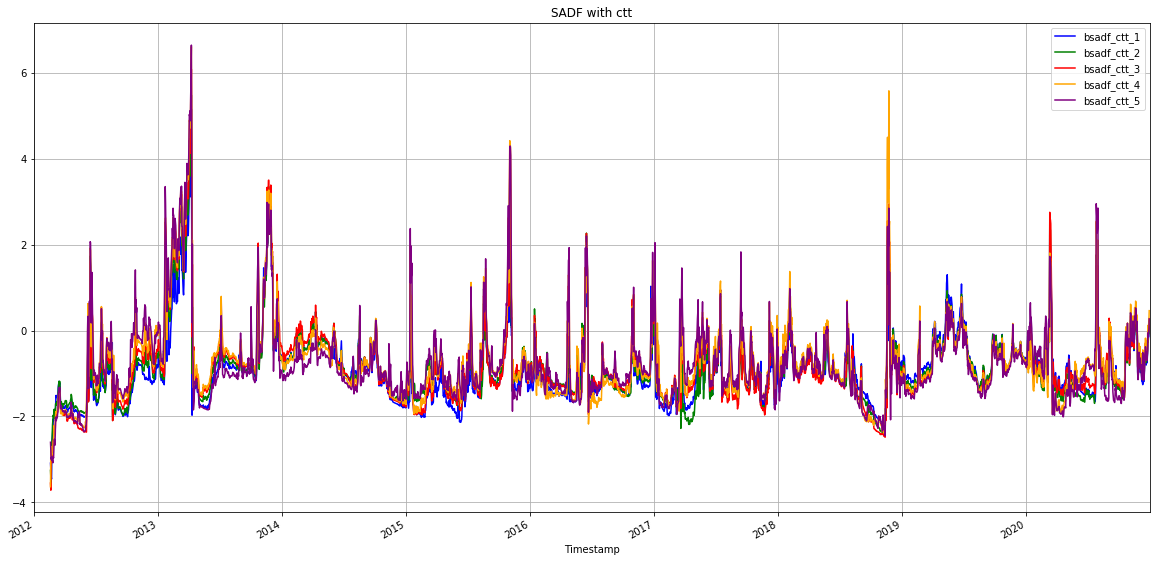

In [41]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
# btc.plot(kind='line',y='Close', color='blue', ax=ax)
btc.plot(kind='line',y='bsadf_ctt_1', color='blue', ax=ax)
btc.plot(kind='line',y='bsadf_ctt_2', color='green', ax=ax)
btc.plot(kind='line',y='bsadf_ctt_3', color='red', ax=ax)
btc.plot(kind='line',y='bsadf_ctt_4', color='orange', ax=ax)
btc.plot(kind='line',y='bsadf_ctt_5', color='purple', ax=ax)
plt.title('SADF with ctt')
plt.grid()
plt.show()

In [ ]:
# Guardamos la diferenciacion fraccionaria para poder reutilizar el codigo luego.
DATA_PATH = '../../datasets/btc_daily_sadf.csv'
btc.to_csv(DATA_PATH, index_label='Timestamp', date_format='%s')